# Python package

We start with importing a few things we'll need. All required packages are installed during the setup process. 

In [9]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from openbabel.pybel import readfile, readstring
import numpy as np

from delfta.calculator import DelftaCalculator
from delfta.utils import DATA_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
mol_files = glob.glob(os.path.join(DATA_PATH, "test_data", "*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value (($\omega$B97X-D/def2-SVP) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [4]:
calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=True) 
# Verbose passing of arguments. We could've used "all" as well
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(tasks="all", delta=False) 
# "all" means ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
predictions_direct = calc_direct.predict(mols)

2021/06/24 12:36:32 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 4/4 [00:05<00:00,  1.31s/it]
2021/06/24 12:36:38 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
2021/06/24 12:36:44 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 4/4 [00:05<00:00,  1.31s/it]
2021/06/24 12:36:49 PM | DelFTa | INFO: Now running xTB...
2021/06/24 12:37:11 PM | DelFTa | INFO: Now running network for model multitask_direct...
100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
2021/06/24 12:37:16 PM | DelFTa | INFO: Now running network for model charges_direct...
100%|██████████| 4/4 [00:05<00:00,  1.38s/it]
2021/06/24 12:37:22 PM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Let's put the output in a dataframe to get an overview: 

In [5]:
df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_form [Ha],E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],charges [e]
0,CHEMBL4289810_conf_02.sdf,-16.472244,-0.301884,0.007817,0.309563,13.094598,"[0.03642187733829498, -0.1121040180570984, -0...."
1,CHEMBL3903980_conf_00.sdf,-11.918853,-0.308223,-0.016024,0.292466,9.587653,"[-0.2632103242055893, 0.09815389717842105, 0.1..."
2,CHEMBL2435942_conf_01.sdf,-12.358029,-0.318627,0.013783,0.332709,5.714915,"[-0.2759720814773941, 0.2659427784486872, -0.2..."
3,CHEMBL3912963_conf_01.sdf,-13.600934,-0.266440,0.037594,0.303944,2.964672,"[0.09122912277095795, -0.4310364495391846, 0.0..."
4,CHEMBL2348937_conf_01.sdf,-7.514140,-0.288944,-0.015563,0.273826,5.199066,"[0.12905866754526138, -0.3222231994758987, 0.2..."
...,...,...,...,...,...,...,...
95,CHEMBL3917059_conf_01.sdf,-13.623294,-0.273591,0.009193,0.283267,11.054542,"[0.05130998585388184, -0.11801440041160584, -0..."
96,CHEMBL227326_conf_00.sdf,-11.970598,-0.287543,0.028540,0.316302,2.909478,"[0.08575782169696808, -0.13629141669425965, -0..."
97,CHEMBL1083965_conf_00.sdf,-7.986115,-0.285511,0.000992,0.286689,2.669335,"[0.09380030532764434, -0.10584346225429535, -0..."
98,CHEMBL209490_conf_02.sdf,-11.515917,-0.298342,0.032551,0.330902,3.573202,"[0.0475099751448822, -0.19532524100776671, -0...."


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [6]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



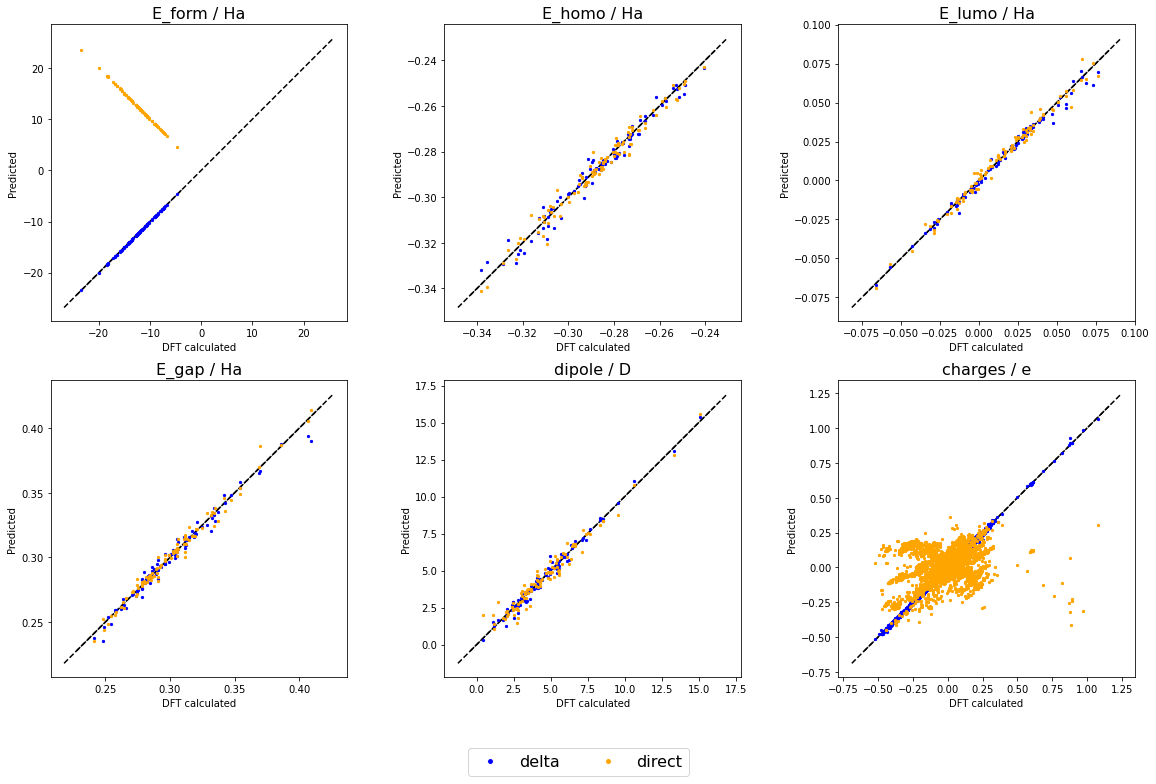

In [7]:
def make_plot(ax, dft_vals, pred_vals, label, unit, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=5)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, dft_vals, pred_vals_delta, pred_vals_direct, label, unit in zip(axes, all_dft_vals, all_pred_vals_delta, all_pred_vals_direct, pred_keys, units): 
    make_plot(ax, dft_vals, pred_vals_delta, label, unit, "blue")
    make_plot(ax, dft_vals, pred_vals_direct, label, unit, "orange")
    ax.title.set_text(f"{label} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see... ADD SOME INTERPRETATION FOR FINAL MODEL

You can also create molecules directly from SMILES. In that case, you need to set `force3D=True`, so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [13]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(tasks="all", delta=True, force3D=True, addh=True)
preds_delta = calc.predict(mols)

2021/06/24 12:40:14 PM | DelFTa | INFO: Assigned MMFF94 coordinates to molecules with idx. [0]
2021/06/24 12:40:14 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 67.56it/s]
2021/06/24 12:40:15 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 68.56it/s]
2021/06/24 12:40:15 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 69.30it/s]
2021/06/24 12:40:15 PM | DelFTa | INFO: Now running xTB...
